In [2]:
from graphviz import Digraph

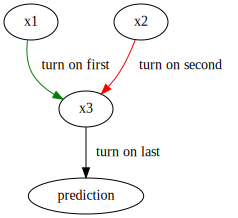

In [23]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('y', 'prediction')

dot.edge('1', '3', 'turn on first', color='green')
dot.edge('2', '3', 'turn on second', color='red')
dot.edge('3', 'y', 'turn on last')
dot

BFS based flow would fail because cannot backprop credit to the green and red edge without linearization.

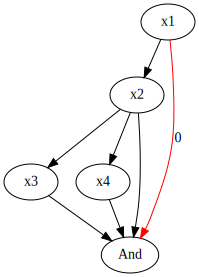

In [28]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And')

dot.edges(['12', '23', '2y', '3y', '24', '4y'])
dot.edge('1', 'y', color='red', label='0')
dot

This fails node first flow (flow0.py) because it assumes the red edge always appear first thus giving 0 contribution to it.

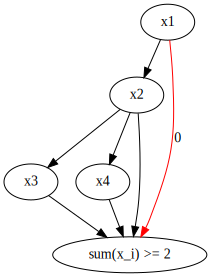

In [32]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'sum(x_i) >= 2')

dot.edges(['12', '23', '2y', '3y', '24', '4y'])
dot.edge('1', 'y', color='red', label='0')
dot

This fails edge first flow (flow1.py) because the red edge can only appear first or last.

### this means edge first flow treats direct connections as unbreakable functions; Is this a reasonable assumption?

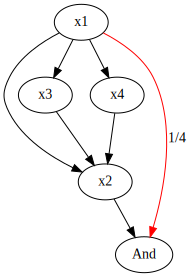

In [33]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And')

dot.edges(['12', '13', '14', '32', '42', '2y'])
dot.edge('1', 'y', color='red', label='1/4')
dot

This fails path first flow (permuting path) because I can make the red edge contribution as little as possible by adding intermediate nodes.

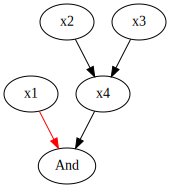

In [25]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And')

dot.edges(['4y', '24', '34'])
dot.edge('1', 'y', color='red')
dot

This fails edge first backtrack (trace from the target instead of from the source) because it assumes x1 happens first twice as often as x2 and x3, which is not a justifiable assumption. Note that path first flow would work in this case (there is no path first back tracing b/c path first assumes every path is equally likely).

## Solutution?

Edge first backtrack to single source: Trace from the target to the sources one at a time in the order of node activation

# The ordering implied by counterfactual questions in feature attribution

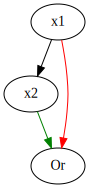

In [5]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('y', 'Or')

dot.edges(['12'])
dot.edge('1', 'y', color='red')
dot.edge('2', 'y', color='green')
dot

In the regular setting, the red and the green edge should have equal weights

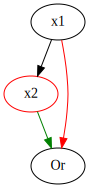

In [6]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2', color='red')
dot.node('y', 'Or')

dot.edges(['12'])
dot.edge('1', 'y', color='red')
dot.edge('2', 'y', color='green')
dot

 Fixing x2 to baseline (0) means only the red edge should get the credit. In a way, fixing variables to baseline makes its impact propagating to the output happen last.

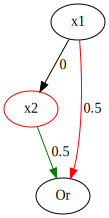

In [13]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2', color='red')
dot.node('y', 'Or')

dot.edge('1', '2', label='0')
dot.edge('1', 'y', color='red', label='0.5')
dot.edge('2', 'y', color='green', label='0.5')
dot

This should be consistent with our counterfactual question. But where does the 0.5 for x2 come from? We can assume each node contains some credit to begin with, in this case x2 has 0.5 credit.

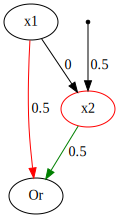

In [17]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2', color='red')
dot.node('3', 'r2', shape='point')
dot.node('y', 'Or')

dot.edge('1', '2', label='0')
dot.edge('3', '2', label='0.5')
dot.edge('1', 'y', color='red', label='0.5')
dot.edge('2', 'y', color='green', label='0.5')
dot

Now the credit has some concrete meaning: it means that if a variable is set to a baseline, **the sum of credit of incoming edges (except for its internal source node) is the amount of decrease in model output**.

# Axiom: expanding a node shouldn't affect contribution

A simple graph


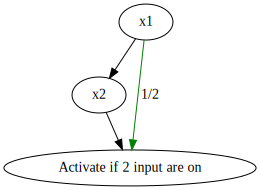

In [26]:
print('A simple graph')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('y', 'Activate if 2 input are on')

dot.edges(['12', '2y'])
dot.edge('1', 'y', color='green', label='1/2')
dot

adding an intermediate node from x1 to x2


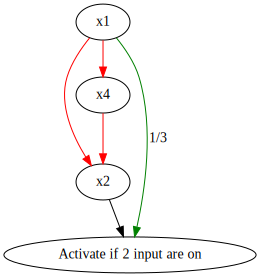

In [25]:
print('adding an intermediate node from x1 to x2')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
# dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'Activate if 2 input are on')

dot.edges(['2y'])
dot.edge('1', 'y', color='green', label='1/3')
dot.edge('1', '4', color='red')
dot.edge('4', '2', color='red')
dot.edge('1', '2', color='red')
dot

This can be resolved by requiring always copy the source node when expanding a computational node.

adding an intermediate node from x1 to x2


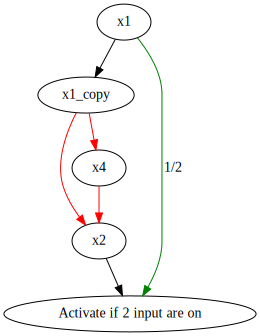

In [36]:
print('adding an intermediate node from x1 to x2')
dot = Digraph()
dot.node('0', 'x1')
dot.node('1', 'x1_copy')
dot.node('2', 'x2')
# dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'Activate if 2 input are on')

dot.edges(['2y'])
dot.edge('0', 'y', color='green', label='1/2')
dot.edge('0', '1')
dot.edge('1', '4', color='red')
dot.edge('4', '2', color='red')
dot.edge('1', '2', color='red')
dot